# Imports

In [200]:
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda")
print(device)

cuda


# Repeatability of results

In [201]:
seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load the dataset

{'Badminton': 0, 'Cricket': 1, 'Tennis': 2, 'Swimming': 3, 'Soccer': 4, 'Wrestling': 5, 'Karate': 6}
The dataset has been loaded.
Class counts in the train dataset:
label
0    1394
1    1556
2    1445
3     595
4    1188
5    1471
6     578
Name: count, dtype: int64


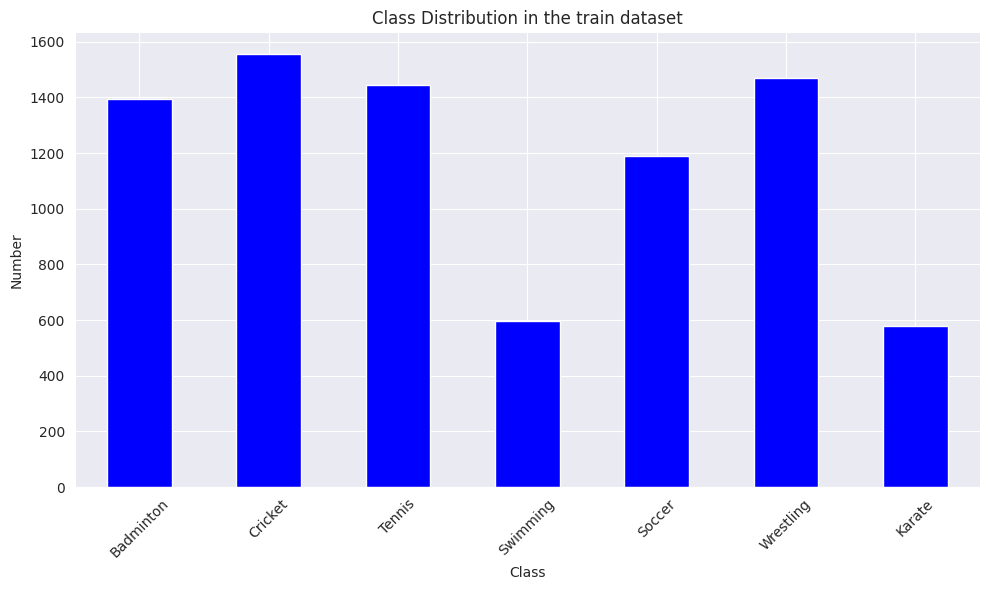

Class counts in the test dataset:
label
0    330
1    377
2    382
3    145
4    309
5    358
6    144
Name: count, dtype: int64


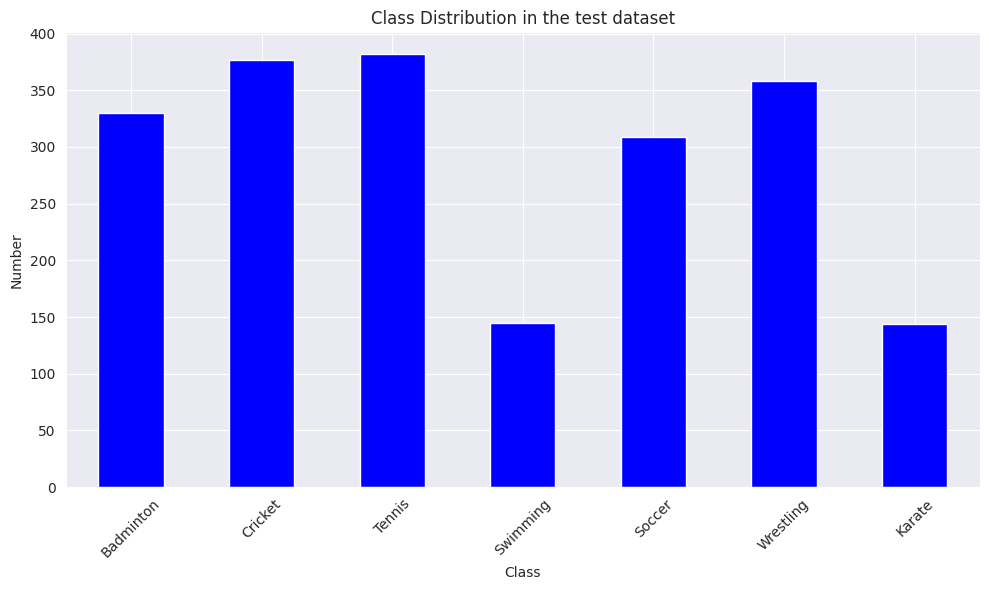

In [202]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

class_names = train_df['label'].unique()
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
print(class_to_idx)

train_df['label'] = train_df['label'].map(class_to_idx)
train_df.to_csv('dataset/train_normalized.csv', index=False)

print("The dataset has been loaded.")

train_class_counts = train_df['label'].value_counts().sort_index()
print("Class counts in the train dataset:")
print(train_class_counts)

plt.figure(figsize=(10, 6))
train_class_counts.plot(kind='bar', color='blue')
plt.title('Class Distribution in the train dataset')
plt.xlabel('Class')
plt.ylabel('Number')
plt.xticks(ticks=range(len(train_class_counts)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()

test_class_counts = test_df['label'].value_counts().sort_index()
print("Class counts in the test dataset:")
print(test_class_counts)

plt.figure(figsize=(10, 6))
test_class_counts.plot(kind='bar', color='blue')
plt.title('Class Distribution in the test dataset')
plt.xlabel('Class')
plt.ylabel('Number')
plt.xticks(ticks=range(len(test_class_counts)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()


In [203]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx, 1]
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

batch_size = 32

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=seed)
train_dataset = ImageDataset(dataframe=train_df, img_dir='dataset/train', transform=transform)
val_dataset = ImageDataset(dataframe=val_df, img_dir='dataset/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator().manual_seed(seed))

test_df = pd.read_csv('dataset/test.csv')
test_dataset = ImageDataset(dataframe=test_df, img_dir='dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator().manual_seed(seed))

# Self made custom neural network model

In [204]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 128)
        
        self.output_layer = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pooling_layer(x)
        
        x = self.relu(self.conv2(x))
        x = self.pooling_layer(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        
        x = self.output_layer(x)
        
        return x


# Training different models for image classification:
- AlexNet
- DenseNet121
- GoogLeNet
- ResNet50
- VGG11
- Custom_model

In [205]:
def initialize_models(num_classes):
    models_dict = {
        "custom_model": {
            "model": CustomModel(num_classes),
            "optimizer": None,
            "name": 'CustomModel'
        },
        "resnet50": {
            "model": models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'ResNet50'
        },
        "vgg11": {
            "model": models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'VGG11'
        }#,
        # "googlenet": {
        #     "model": models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1),
        #     "optimizer": None,
        #     "name": 'GoogLeNet'
        # },
        # "alexnet": {
        #     "model": models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1),
        #     "optimizer": None,
        #     "name": 'AlexNet'
        # },
        # "densenet121": {
        #     "model": models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1),
        #     "optimizer": None,
        #     "name": 'DenseNet121'
        # }
    }

    for model_key, model_info in models_dict.items():
        model = model_info["model"]
        
        if model_key == "resnet50" or model_key == "googlenet":
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_key == "vgg11" or model_key == "alexnet":
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_key == "densenet121":
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        elif model_key == "custom_model":
            model.output_layer = nn.Linear(model.output_layer.in_features, num_classes)
        
        if model_key != "custom_model":
            for param in model.parameters():
                param.requires_grad = False

            if model_key == "resnet50" or model_key == "googlenet":
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif model_key == "vgg11" or model_key == "alexnet":
                for param in model.classifier[6].parameters():
                    param.requires_grad = True
            elif model_key == "densenet121":
                for param in model.classifier.parameters():
                    param.requires_grad = True
        
        models_dict[model_key]["model"] = model.to(device)
        models_dict[model_key]["optimizer"] = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    return models_dict


def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc

In [206]:
# Training parameters
num_classes = len(class_names)
models_dict = initialize_models(num_classes)
criterion = nn.CrossEntropyLoss()
best_val_acc_dict = {model_key: 0.0 for model_key in models_dict.keys()}
num_epochs = 10

# Early stopping parameters
patience = 3
counter_without_improvement = {model_key: 0 for model_key in models_dict.keys()}
completed_training_flag = {model_key: False for model_key in models_dict.keys()}

Epoch 1/10
------------------------------------------------------------
CustomModel - Train Loss: 1.7204, Train Acc: 0.3164
CustomModel - Val Loss: 1.2612, Val Acc: 0.5498
CustomModel - model saved with improved validation accuracy.
ResNet50 - Train Loss: 0.7842, Train Acc: 0.7604
ResNet50 - Val Loss: 0.4505, Val Acc: 0.8657
ResNet50 - model saved with improved validation accuracy.
VGG11 - Train Loss: 0.8166, Train Acc: 0.7143
VGG11 - Val Loss: 0.5360, Val Acc: 0.8190
VGG11 - model saved with improved validation accuracy.
Epoch 2/10
------------------------------------------------------------
CustomModel - Train Loss: 1.2561, Train Acc: 0.5440
CustomModel - Val Loss: 0.9937, Val Acc: 0.6452
CustomModel - model saved with improved validation accuracy.
ResNet50 - Train Loss: 0.4487, Train Acc: 0.8645
ResNet50 - Val Loss: 0.3805, Val Acc: 0.8706
ResNet50 - model saved with improved validation accuracy.
VGG11 - Train Loss: 0.5974, Train Acc: 0.7880
VGG11 - Val Loss: 0.4526, Val Acc: 0.8445

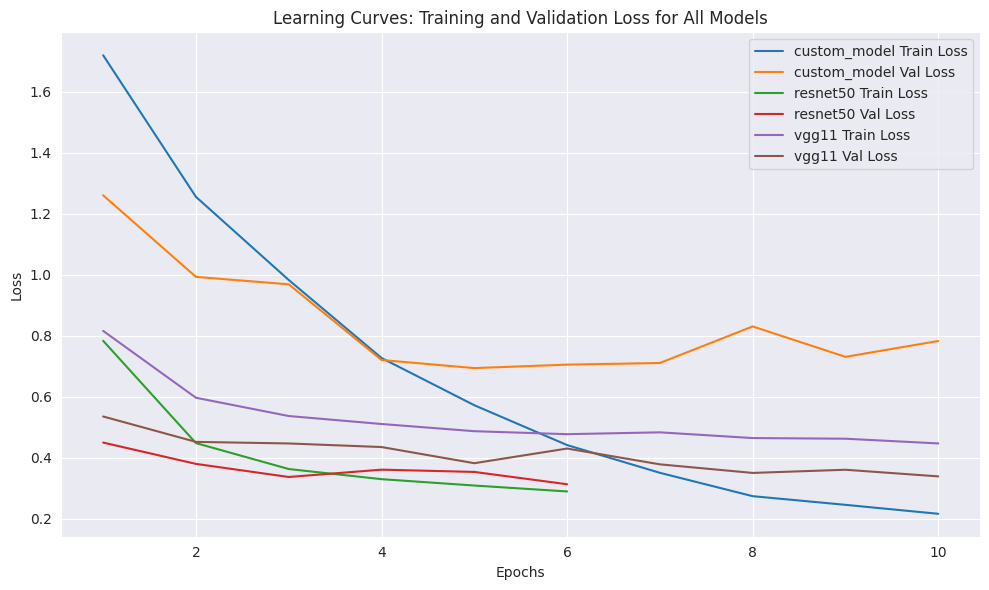

In [207]:
if not os.path.exists('Saved_states/'):
    os.makedirs('Saved_states/')

learning_curves = {
    'train_loss': {model_key: [] for model_key in models_dict.keys()},
    'val_loss': {model_key: [] for model_key in models_dict.keys()},
    'train_acc': {model_key: [] for model_key in models_dict.keys()},
    'val_acc': {model_key: [] for model_key in models_dict.keys()},
}

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 60)

    for model_key, model_info in models_dict.items():
        model = model_info["model"]
        optimizer = model_info["optimizer"]
        model_name = model_info["name"]
        
        if completed_training_flag[model_key] == False:
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
            val_loss, val_acc = evaluate_model(model, val_loader, criterion)
            
            learning_curves['train_loss'][model_key].append(train_loss)
            learning_curves['val_loss'][model_key].append(val_loss)
            learning_curves['train_acc'][model_key].append(train_acc)
            learning_curves['val_acc'][model_key].append(val_acc)
    
            print(f'{model_name} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'{model_name} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}') 
    
            if val_acc > best_val_acc_dict[model_key]:
                best_val_acc_dict[model_key] = val_acc
                torch.save(model.state_dict(), f'Saved_states/best_{model_key}_model.pth')
                print(f"{model_name} - model saved with improved validation accuracy.")
                counter_without_improvement[model_key] = 0
            else:
                counter_without_improvement[model_key] += 1
                if counter_without_improvement[model_key] >= patience:
                    print(f"{model_name} model has not improved for {patience} epochs. Early stopping.")
                    completed_training_flag[model_key] = True

print("\nTraining phase completed.")


def plot_learning_curves():
    plt.figure(figsize=(10, 6))
    
    for model_key in models_dict.keys():
        train_loss = learning_curves['train_loss'][model_key]
        val_loss = learning_curves['val_loss'][model_key]
        num_epochs_trained = len(train_loss)
        
        plt.plot(range(1, num_epochs_trained + 1), train_loss, label=f'{model_key} Train Loss')
        
        plt.plot(range(1, num_epochs_trained + 1), val_loss, label=f'{model_key} Val Loss')

    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curves()

# Model evaluation based on test data


Testowanie modelu: CustomModel
F1 Score for CustomModel: 0.7876


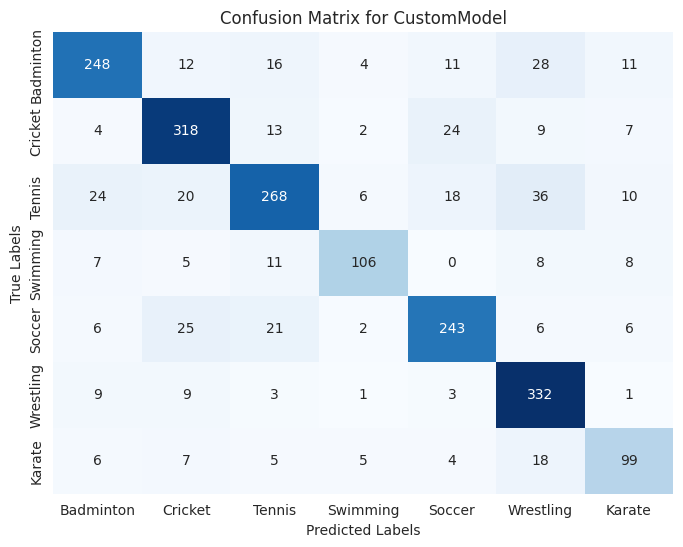


Testowanie modelu: ResNet50
F1 Score for ResNet50: 0.8959


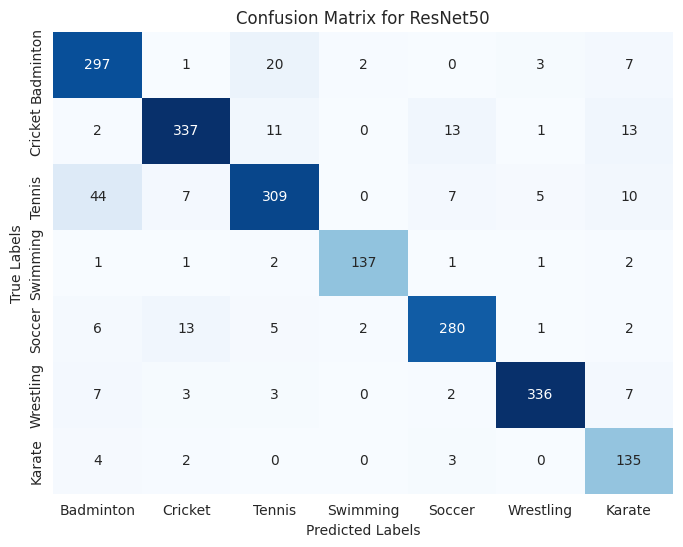


Testowanie modelu: VGG11
F1 Score for VGG11: 0.8860


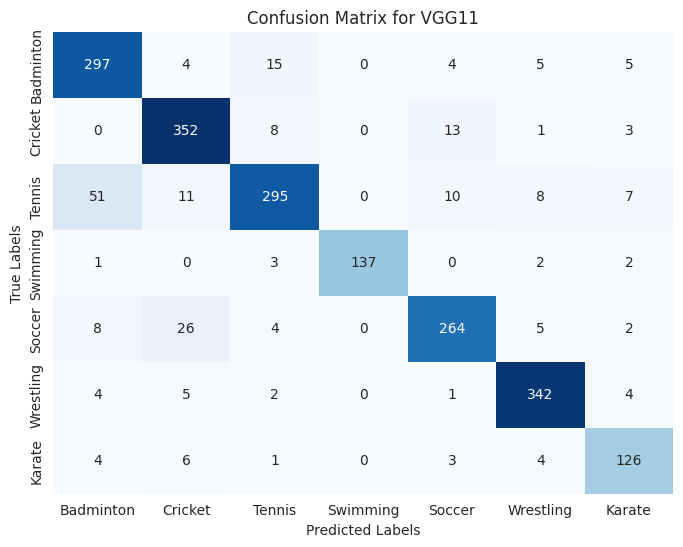

In [208]:
def load_trained_models(num_classes):
    models_dict = initialize_models(num_classes)

    for model_key in models_dict.keys():
        model_path = f'Saved_states/best_{model_key}_model.pth'
        
        if os.path.exists(model_path):
            state_dict = torch.load(model_path, map_location=device, weights_only=True)
            models_dict[model_key]["model"].load_state_dict(state_dict)

    return models_dict


def test_model(model, test_loader, model_name):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score for {model_name}: {f1:.4f}')
    
    cm = confusion_matrix(all_labels, all_preds)

    class_names_sorted = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names_sorted, yticklabels=class_names_sorted)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

trained_models_dict = load_trained_models(num_classes)

for model_key, model_info in trained_models_dict.items():
    print(f'\nTestowanie modelu: {model_info["name"]}')
    test_model(model_info["model"], test_loader, model_info["name"])